In [51]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib.colors as mcolors


In [35]:
mat_data = h5py.File("data/assignmentSegmentBrainGmmEmMrf.mat", "r")
data = np.array(mat_data['imageData'])
data_mask = np.array(mat_data['imageMask'])

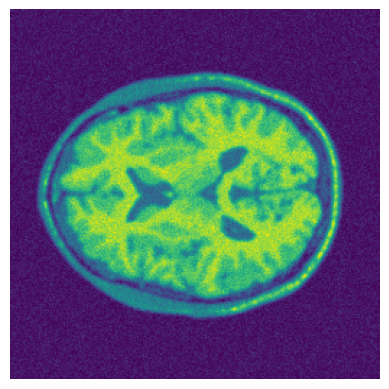

In [36]:
def save_image(data: np.ndarray, filename):
    """
    Extracts image data from a .mat file, normalizes it, and saves it as a PNG file.

    Parameters:
        data (np.ndarray): input data (expected shape: (channels, height, width))
        filename (str): Name of the file to save the image to.
    """

    data_normalized = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

    if data_normalized.shape[0] == 3:
        data_normalized = np.transpose(data_normalized, (1, 2, 0))

    plt.imshow(data_normalized)
    plt.axis("off")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    
save_image(data, "image.png")


In [52]:
def k_means(data: np.ndarray, k: int, max_iter: int = 1000, tol: float = 1e-4):
    """
    Performs K-means clustering and computes means and covariances.

    Parameters:
        data (np.ndarray): input data (H x W)
        k (int): number of clusters
        max_iter (int): maximum number of iterations
        tol (float): tolerance for convergence

    Returns:
        np.ndarray: labels (H, W)
        np.ndarray: means (k x 1)
        np.ndarray: covariances (k x 1)
    """
    height, width = data.shape
    flattened_data = data.flatten()  # Convert to (H*W,) shape

    # Step 1: Initialize cluster centers randomly
    np.random.seed(10)  # For reproducibility
    means = np.random.choice(flattened_data, k, replace=False)

    labels = np.zeros(flattened_data.shape, dtype=int)

    for iteration in range(max_iter):
        # Step 2: Assign each pixel to the nearest cluster center
        distances = np.abs(flattened_data[:, None] - means[None, :])  # (H*W, k)
        new_labels = np.argmin(distances, axis=1)  # (H*W,)

        # Step 3: Compute new means
        new_means = np.array([
            flattened_data[new_labels == l].mean() if np.any(new_labels == l) else means[l]
            for l in range(k)
        ])

        # Step 4: Check for convergence
        if np.linalg.norm(new_means - means) < tol:
            break

        means = new_means
        labels = new_labels

    # Reshape labels back to (H, W)
    labels = labels.reshape(height, width)

    # Compute covariances
    covariances = np.array([
        np.var(flattened_data[labels.flatten() == l]) if np.any(labels.flatten() == l) else 1.0
        for l in range(k)
    ])

    return labels, means, covariances


In [49]:
k_means(data, 3)

(array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]]),
 array([0.57590336, 0.31801831, 0.04829171]),
 array([0.00430834, 0.00499396, 0.0009535 ]))

In [53]:
def compute_mrf_prior(labels, num_labels, beta, mask):
    """
    Compute the MRF prior energy for a given 2D data using a 4-neighbor system.

    Args:
        labels (numpy.ndarray): 2D array representing label assignments.
        num_labels (int): number of labels in the dataset.
        beta (float): Smoothing parameter.
        mask (numpy.ndarray): 2D binary mask indicating which pixels to use.

    Returns:
        numpy.ndarray: Prior energy for each pixel and label.
    """
    height, width = labels.shape

    prior = np.zeros((height, width, num_labels))  # 3D array for prior values

    # Iterate over each pixel
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0:  # Skip masked-out pixels
                continue

            for l in range(num_labels):  # Iterate over labels
                smoothness = 0  # Reset count for this label

                # Check 4-neighbor system
                if j < width - 1 and mask[i, j + 1] and labels[i, j + 1] == l:  # Right neighbor
                    smoothness += 1
                if i < height - 1 and mask[i + 1, j] and labels[i + 1, j] == l:  # Bottom neighbor
                    smoothness += 1
                if j > 0 and mask[i, j - 1] and labels[i, j - 1] == l:  # Left neighbor
                    smoothness += 1
                if i > 0 and mask[i - 1, j] and labels[i - 1, j] == l:  # Top neighbor
                    smoothness += 1

                # Compute prior probability
                prior[i, j, l] = np.exp(beta * smoothness)

    return prior

In [54]:
def generate_labels(data, labels, means, covs, beta, mask):
    """
    Performs the E-step of the EM algorithm and returns the memberships
    :param data: (H x W)
    :param labels: (H x W)
    :param means: (k x 1)
    :param covs: (k x 1)
    :return: new labels (H x W)
    """

    height, width = data.shape
    num_labels = len(means)

    # Compute the likelihood
    likelihood = np.zeros((height, width, len(means)))
    for l in range(num_labels):
        likelihood[:, :, l] = (1 / (np.sqrt(2 * np.pi) * covs[l])) * np.exp(-0.5 * (data - means[l]) ** 2 / covs[l])

    # Compute Prior
    prior = compute_mrf_prior(labels, num_labels, beta, mask)

    posterior = prior * likelihood
    posterior = posterior / np.sum(posterior, axis=2, keepdims=True)

    prev_posterior = 0
    post_posterior = 0

    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0:
                continue
            prev_posterior += np.log(posterior[i, j, labels[i, j]])
            post_posterior += np.log(np.max(posterior[i, j, :]))

    # Update labels
    for i in range(height):
        for j in range(width):
            labels[i, j] = np.argmax(posterior[i, j])

    return labels, prev_posterior, post_posterior

In [55]:

def generate_memberships(data, labels, means, covs, beta, mask, prior):
    """
    Performs the E-step of the EM algorithm and returns the memberships,
    explicitly iterating over each pixel.

    Args:
        data (numpy.ndarray): 2D array (H x W) of input data.
        labels (numpy.ndarray): 2D array (H x W) of labels.
        means (numpy.ndarray): 1D array (k,) of mean values.
        covs (numpy.ndarray): 1D array (k,) of covariance values.
        beta (float): Smoothing parameter for the MRF prior.
        mask (numpy.ndarray): 2D binary mask (H x W), where 1 means valid pixel.
        prior (numpy.ndarray): 3D array (H x W x k) of MRF prior values.

    Returns:
        numpy.ndarray: New membership values (H x W x k).
    """

    height, width = data.shape
    num_labels = len(means)
    memberships = np.zeros((height, width, num_labels))

    # Iterate over all pixels
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0:  # Skip masked-out pixels
                continue

            likelihood = np.zeros(num_labels)

            # Compute likelihood for each label
            for l in range(num_labels):
                likelihood[l] = (1 / (np.sqrt(2 * np.pi) * (covs[l] + 1e-6))) * np.exp(
                    -0.5 * ((data[i, j] - means[l]) ** 2) / (covs[l] + 1e-6)
                )

            # Compute posterior for this pixel
            posterior = prior[i, j, :] * likelihood
            posterior /= np.sum(posterior) + 1e-10  # Normalize, avoid division by zero

            # Store in memberships
            memberships[i, j, :] = posterior

    return memberships

In [56]:
def compute_means_covs(data, memberships, num_labels):
    """
    Computes the means and covariances of the data given the memberships.

    Args:
        data (numpy.ndarray): 2D array (H x W).
        memberships (numpy.ndarray): 3D array (H x W x k) representing soft cluster assignments.
        num_labels (int): Number of clusters (k).

    Returns:
        tuple: (means (k,), covariances (k,))
    """

    height, width = data.shape
    means = np.zeros(num_labels)
    covs = np.zeros(num_labels)

    for l in range(num_labels):
        weight_sum = np.sum(memberships[:, :, l])

        if weight_sum == 0:  # Avoid division by zero
            means[l] = 0
            covs[l] = 0
            continue

        means[l] = np.sum(data * memberships[:, :, l]) / weight_sum
        covs[l] = np.sum(((data - means[l]) ** 2) * memberships[:, :, l]) / weight_sum

    return means, covs



/tmp/ipykernel_142658/3965189930.py:23: RuntimeWarning: invalid value encountered in divide
  posterior = posterior / np.sum(posterior, axis=2, keepdims=True)


0 -4495.427558877949 -267.39232342808134
1 -1439.4474251224517 -276.9797881510078
2 -1791.9286939665826 -247.40882001784655
3 -1461.662409644655 -267.70158395582575
4 -1735.4691395417801 -241.49461593377174
5 -1515.783974146775 -260.7695319185458
6 -1797.9981369315187 -238.7783179219195
7 -1585.6378615346302 -257.1884605363963
8 -1913.2017857343503 -238.56622149047257
9 -1690.251740340904 -256.7914692906052
10 -1933.1027005445571 -238.56295029315925
11 -1690.2517378137818 -256.7914922295161
12 -1933.1027092075847 -238.56295397752245
13 -1690.2517377211107 -256.7914931104584
14 -1933.1027095396855 -238.56295411917466
15 -1690.2517377176557 -256.79149314426826
16 -1933.1027095524169 -238.56295412461512
17 -1690.251737717524 -256.7914931455658
18 -1933.1027095529075 -238.56295412482416
19 -1690.2517377175234 -256.79149314561516
20 -1933.102709552926 -238.562954124832
21 -1690.2517377175209 -256.7914931456169
22 -1933.1027095529255 -238.56295412483217
23 -1690.2517377175207 -256.7914931456

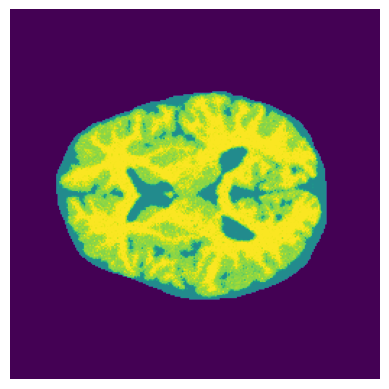

In [59]:
def EM(data, mask, beta):
    """
    Perform the EM algorithm on the input data.

    Args:
        data (numpy.ndarray): 2D array (H x W) of input data.

    Returns:
        Reconstructed image, final memberships, and beta value.
    """

    # Initialize parameters
    num_labels = 3

    max_iter = 30
    # beta_values = np.linspace(0.1, 5, 1)


        # Initialize labels
    labels, means, covs = k_means(data, num_labels)
    labels = labels.reshape(data.shape)

    # Initialize means and covariances

    # Initialize MRF prior
    prior = compute_mrf_prior(labels, num_labels, beta, mask)
    memberships = None

    for num_iter in range(max_iter):
        # Update labels
        labels, prev_posterior, post_posterior = generate_labels(data, labels, means, covs, beta, mask)

        # E-step
        memberships = generate_memberships(data, labels, means, covs, beta, mask, prior)

        # M-step
        means, covs = compute_means_covs(data, memberships, num_labels)

        print(num_iter, prev_posterior, post_posterior)
        if num_iter == max_iter-1:
            print("Means and covs: ", means, covs)

    return np.sum(memberships * means.reshape(1, 1, -1), axis=2), memberships, beta

reconstructed_image, final_memberships, beta = EM(data, data_mask, 4)
zero_image, zero_membership, zero_beta = EM(data, data_mask, 0)
save_image(reconstructed_image, "reconstructed_image.png")
save_image(zero_image, "zero_image.png")

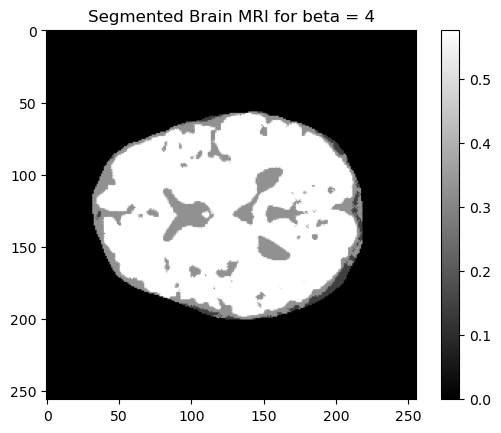

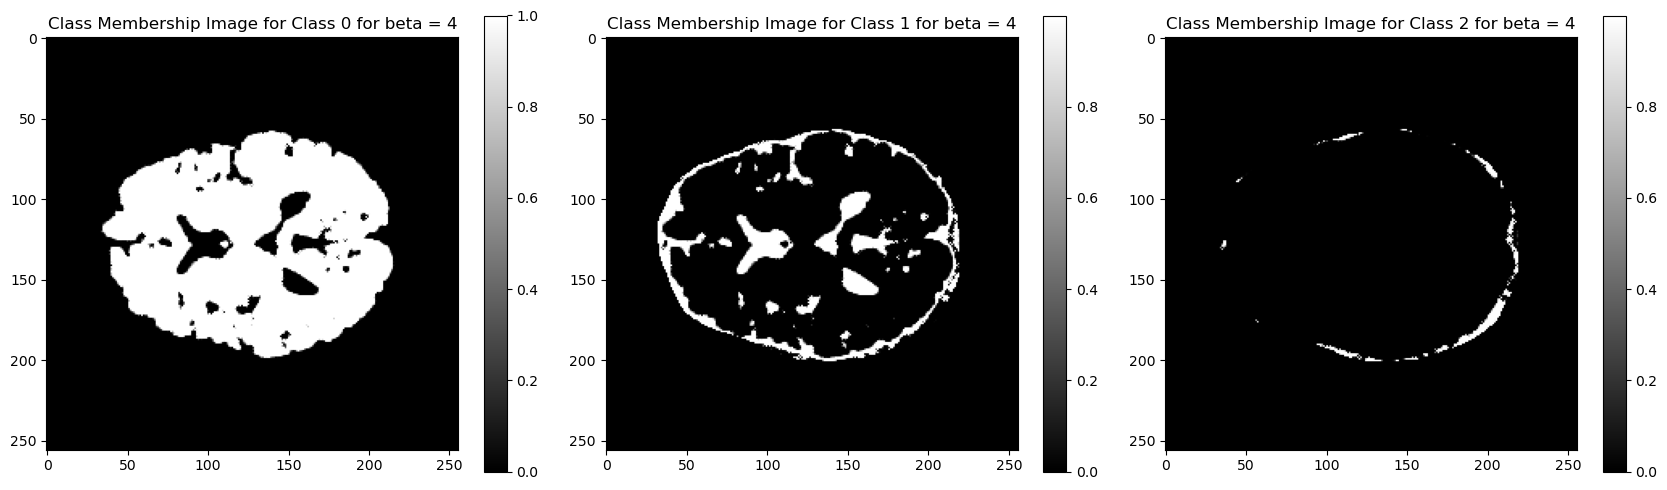

In [60]:
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Segmented Brain MRI for beta = {beta}")
plt.colorbar()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Display images and add colorbars
im0 = axes[0].imshow(final_memberships[:, :, 0], cmap='gray')
axes[0].set_title(f"Class Membership Image for Class 0 for beta = {beta}")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(final_memberships[:, :, 1], cmap='gray')
axes[1].set_title(f"Class Membership Image for Class 1 for beta = {beta}")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(final_memberships[:, :, 2], cmap='gray')
axes[2].set_title(f"Class Membership Image for Class 2 for beta = {beta}")
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

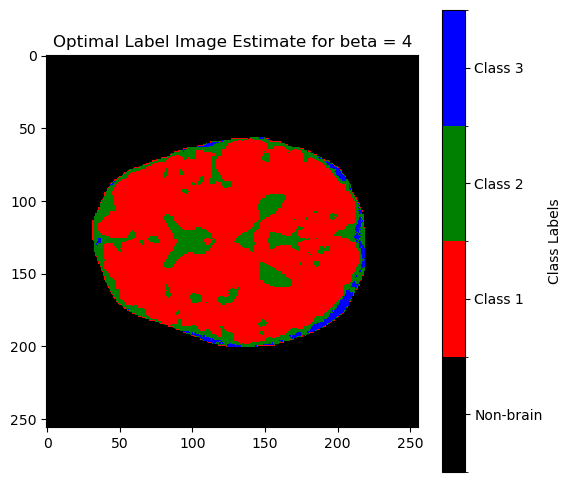

In [61]:
label_estimates = np.argmax(final_memberships, axis=2) + 1  # Ensure labels are 1, 2, or 3
label_estimates[data_mask == 0] = 0  # Set non-brain regions to 0

# Define a discrete colormap
cmap = mcolors.ListedColormap(["black", "red", "green", "blue"])  # 0 -> black, 1 -> red, 2 -> green, 3 -> blue
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Define class boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the labeled image
plt.figure(figsize=(6, 6))
im = plt.imshow(label_estimates, cmap=cmap, norm=norm)

# Create discrete colorbar
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.set_label("Class Labels")
cbar.ax.set_yticklabels(["Non-brain", "Class 1", "Class 2", "Class 3"])  # Label the ticks

plt.title(f"Optimal Label Image Estimate for beta = {beta}")
plt.show()

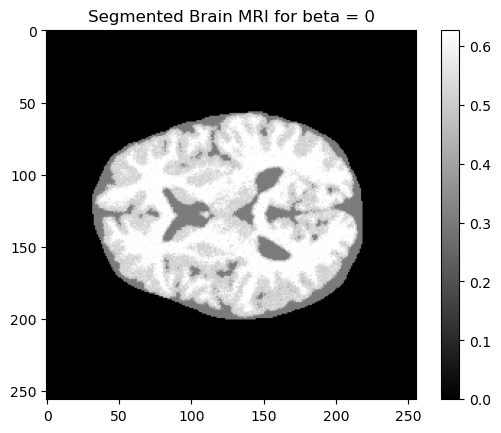

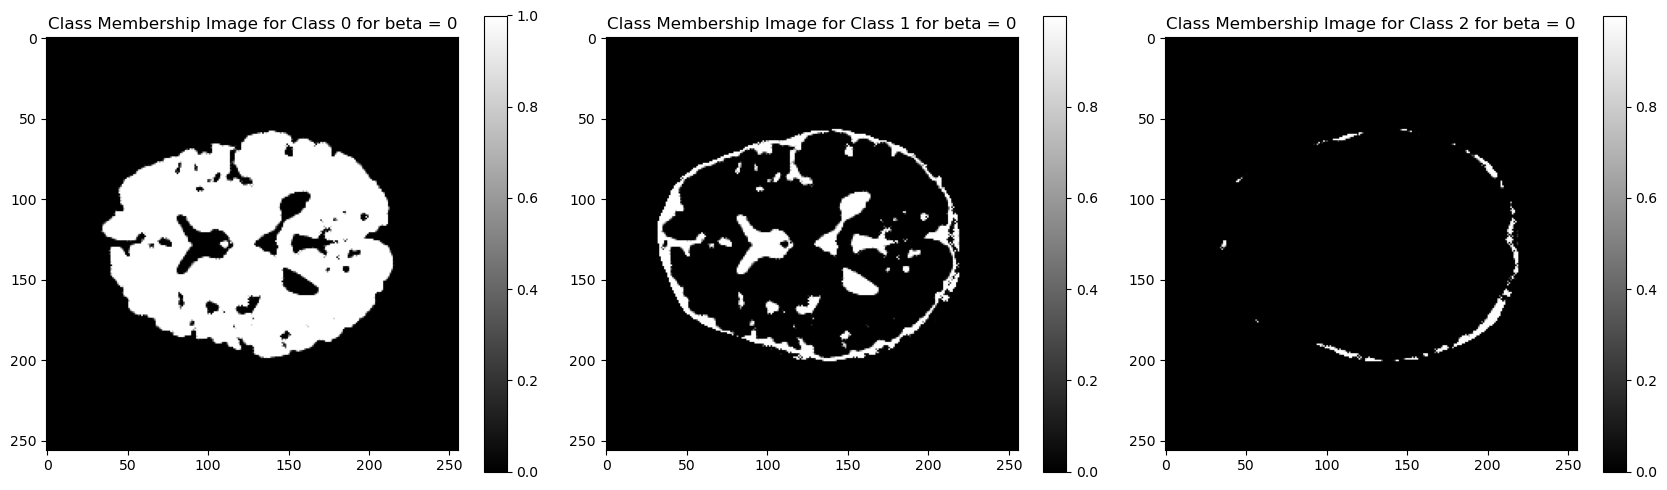

In [62]:
plt.imshow(zero_image, cmap='gray')
plt.title(f"Segmented Brain MRI for beta = {zero_beta}")
plt.colorbar()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Display images and add colorbars
im0 = axes[0].imshow(final_memberships[:, :, 0], cmap='gray')
axes[0].set_title(f"Class Membership Image for Class 0 for beta = {zero_beta}")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(final_memberships[:, :, 1], cmap='gray')
axes[1].set_title(f"Class Membership Image for Class 1 for beta = {zero_beta}")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(final_memberships[:, :, 2], cmap='gray')
axes[2].set_title(f"Class Membership Image for Class 2 for beta = {zero_beta}")
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

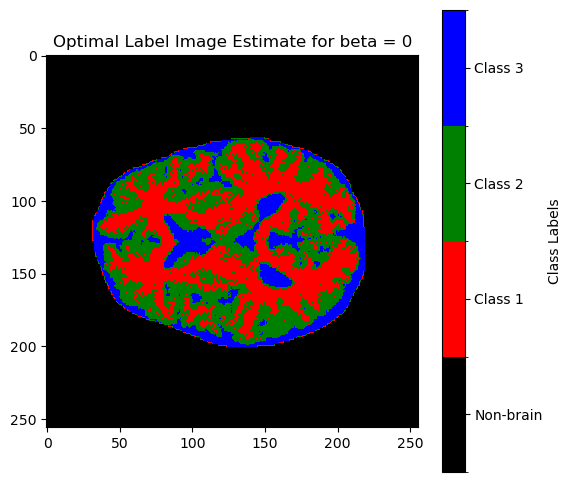

In [63]:
label_estimates = np.argmax(zero_membership, axis=2) + 1  # Ensure labels are 1, 2, or 3
label_estimates[data_mask == 0] = 0  # Set non-brain regions to 0

# Define a discrete colormap
cmap = mcolors.ListedColormap(["black", "red", "green", "blue"])  # 0 -> black, 1 -> red, 2 -> green, 3 -> blue
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]  # Define class boundaries
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the labeled image
plt.figure(figsize=(6, 6))
im = plt.imshow(label_estimates, cmap=cmap, norm=norm)

# Create discrete colorbar
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3])
cbar.set_label("Class Labels")
cbar.ax.set_yticklabels(["Non-brain", "Class 1", "Class 2", "Class 3"])  # Label the ticks

plt.title(f"Optimal Label Image Estimate for beta = {zero_beta}")
plt.show()